## This script will (hopefully) generate 2D training data from stock prices for a CNN

### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import alpaca_trade_api as tradeapi
import pandas as pd

# Set defaults for plotting
from IPython import display
%matplotlib inline
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (7, 5)

import warnings
warnings.simplefilter('ignore')
#warnings.filterwarnings(action='once') # 'ignore'

### Define constants

In [6]:
key_dir = 'C:\\Users\\Dan\\Documents\\Python Scripts\\apiKeys\\'
apiKey = open(key_dir + 'alpaca_apiKey.txt', 'r').read()
secretKey = open(key_dir + 'alpaca_secretKey.txt', 'r').read()
endPoint = 'https://paper-api.alpaca.markets'  # Specify this for demo account

# Define the companies you want the data for
tickers = ['AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'DIS', 'DOW', 'XOM',
           'HD', 'IBM', 'INTC', 'JNJ', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT',
           'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'V', 'WMT', 'WBA']

# Define dates and time window (Pull training data from bull market period, notably prior to coronavirus)
startDate = '2018-10-01'
endDate = '2019-10-01'
timeWindow = 20  # Number of time periods that will comprise the gramian angular field
timeIncrement = 'day'

# Connect to the API and pull the data
api = tradeapi.REST(apiKey, secretKey, endPoint, api_version='v2')

### Interface with the brokerage

In [7]:
# Define the dictionary that will hold all the data for all the companies
ohlcv = {}
for ticker in tickers:
    try:
        # Pull the stock details for that ticker
        ohlcv[ticker] = api.get_aggs(ticker, 1, timeIncrement, startDate, endDate).df
        # Calculate their daily return
        ohlcv[ticker]['daily return'] = ohlcv[ticker]['close'].pct_change()
        print('Pulling ohlcv data for {:s}'.format(ticker))
    except:
        # If nothing is found, throw error and continue
        print('Error encountered pulling ohlcv data for {:s}'.format(ticker))

Pulling ohlcv data for AXP
Pulling ohlcv data for AAPL
Pulling ohlcv data for BA
Pulling ohlcv data for CAT
Pulling ohlcv data for CVX
Pulling ohlcv data for CSCO
Pulling ohlcv data for DIS
Pulling ohlcv data for DOW
Pulling ohlcv data for XOM
Pulling ohlcv data for HD
Pulling ohlcv data for IBM
Pulling ohlcv data for INTC
Pulling ohlcv data for JNJ
Pulling ohlcv data for KO
Pulling ohlcv data for MCD
Pulling ohlcv data for MMM
Pulling ohlcv data for MRK
Pulling ohlcv data for MSFT
Pulling ohlcv data for NKE
Pulling ohlcv data for PFE
Pulling ohlcv data for PG
Pulling ohlcv data for TRV
Pulling ohlcv data for UTX
Pulling ohlcv data for UNH
Pulling ohlcv data for VZ
Pulling ohlcv data for V
Pulling ohlcv data for WMT
Pulling ohlcv data for WBA


In [12]:
# Check it's pulling data from the whole date range
print(ohlcv['WBA'].index[-1], ohlcv['WBA'].index[0])

2019-10-01 00:00:00-04:00 2018-10-01 00:00:00-04:00


### Loop over the data and for each time window extract a gramian angular field

In [9]:
# 1 for save data, 0 for no saving, only plotting for inspection
saveToFile = 1
# For 1 year, with 28 tickers, this yields on average 3250 images for buy and the same for sell.
# Over 2018-2019, there are slightly more buy images than sell (3500 vs 3000), accounted for by the bullish market during that time

for ticker in tickers:

    for i in range(len(ohlcv[ticker]) - 1 - timeWindow - 1):
        
        # Calculate the gramian angular field here
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaler.fit(ohlcv[ticker]['close'].iloc[i:i+timeWindow].to_numpy().reshape(timeWindow, -1))
        data_scaled = scaler.transform(ohlcv[ticker]['close'].iloc[i:i+timeWindow].to_numpy().reshape(timeWindow, -1))
        phi = np.arccos(data_scaled)
        gram = np.vectorize(lambda x,y: np.cos(x + y))(*np.meshgrid(phi, phi, sparse=True))

        if saveToFile == 1:

            fileName = 'gramian_' + ticker + '_' + str(i).zfill(3)

            # If the next close price is higher than the last one in the window, it should be interpreted as a buy signal.
            if ohlcv[ticker]['close'].iloc[i+timeWindow] < ohlcv[ticker]['close'].iloc[i+timeWindow+1]:
                print('Buy signal for ' + ticker + '. i = ' + str(i) + '/' + str(len(ohlcv[ticker]) - 1 - timeWindow - 1), end="\r")
                np.save('./trainingData_Gramian/buy/' + fileName + '.npy', gram)
            else:
                print('Sell signal for ' + ticker + '. i = ' + str(i) + '/' + str(len(ohlcv[ticker]) - 1 - timeWindow - 1), end="\r")
                np.save('./trainingData_Gramian/sell/' + fileName + '.npy', gram)
        
        else:

            plt.figure(figsize=(15,6), num=1)

            # Plot the time series
            plt.subplot(1, 2, 1)
            plt.plot(data_scaled)
            plt.gcf().autofmt_xdate()
            plt.title('Scaled close price')

            # Plot the gramian angular summation field
            plt.subplot(1, 2, 2)
            plt.imshow(gram)
            plt.axis(False)
            plt.title('Gramian angular summation field')

            # Update the plot(s)
            display.clear_output(wait=True)
            plt.pause(0.05)
        
    print('\n')

Sell signal for AXP. i = 227/228

Buy signal for AAPL. i = 229/2300

Sell signal for BA. i = 229/230

Sell signal for CAT. i = 229/230

Sell signal for CVX. i = 229/230

Buy signal for CSCO. i = 229/2300

Buy signal for DIS. i = 229/2300

Buy signal for DOW. i = 103/1044

Sell signal for XOM. i = 229/230

Buy signal for HD. i = 229/2300

Buy signal for IBM. i = 229/2300

Buy signal for INTC. i = 229/2300

Buy signal for JNJ. i = 229/2300

Buy signal for KO. i = 229/2300

Buy signal for MCD. i = 229/2300

Sell signal for MMM. i = 227/228

Buy signal for MRK. i = 229/2300

Buy signal for MSFT. i = 229/2300

Buy signal for NKE. i = 229/2300

Sell signal for PFE. i = 229/230

Sell signal for PG. i = 229/230

Buy signal for TRV. i = 228/2299

Buy signal for UTX. i = 229/2300

Buy signal for UNH. i = 227/2288

Buy signal for VZ. i = 229/2300

Sell signal for V. i = 229/230

Buy signal for WMT. i = 229/2300

Buy signal for WBA. i = 229/2300



### Check to see if the saved numpy arrays have been saved properly

Note that the numpy arrays are saved as greyscale. If you wanted to save rgb, the data would occupy three times the space

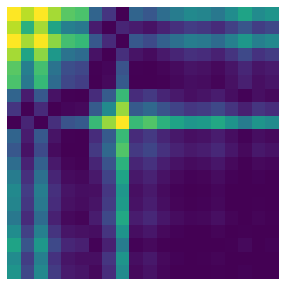

In [10]:
test = np.load('./trainingData_Gramian/buy/' + fileName + '.npy')  # Just grab the last one that was saved in ./buy
plt.imshow(test)
plt.axis(False)
plt.show()  # Looks good.

Check if you want these fields to use overlapping data

### Code for saving a figure to a file in the cwd

In [43]:
'''Note that this way of saving a figure is very slow, and if implemented in a loop, 
the loops will slow down further with each iteration'''

#fig1 = plt.gcf()
#plt.imshow(gram)
#plt.axis(False)
#plt.draw()
#plt.savefig('./trainingData_Gramian/test.png', dpi=5.5, frameon=False, bbox_inches='tight', pad_inches=0)

# To save the data directly, rather than the figure in its entirety:
#plt.imsave('test.png', data, cmap = plt.cm.gray)